# Task 4: Game Title Detection
* This task were mainly run on Colab
* But some task were perform locally before uploading into Colab

# 1.Import LIB & Dependencies

In [ ]:
import os
from google.colab import drive

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import cv2

import shutil
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Config

In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/KMUTT/ML_Task4'
LOCAL_PATH = '/content/data'
TRAIN_IMG_DIR = os.path.join(LOCAL_PATH, 'train')
TRAIN_VALID_DIR = os.path.join(LOCAL_PATH, 'train_valid_denoise')
VALID_IMG_DIR = os.path.join(LOCAL_PATH, 'val')
TEST_IMG_DIR  = os.path.join(LOCAL_PATH, 'test')

TRAIN_CSV = os.path.join(LOCAL_PATH, 'train.csv')
TRAIN_VALID_CSV = os.path.join(LOCAL_PATH, 'train_valid_clean.csv')
VALID_CSV = os.path.join(LOCAL_PATH, 'val.csv')
TEST_CSV  = os.path.join(LOCAL_PATH, 'test.csv')

# --- Model & Training Params ---
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE   = 224
BATCH_SIZE = 32

# --- Data Class ---
data_class = {
    0 : "7-11K",
    1 : "fiveN",
    2 : "freefried",
    3 : "pube",
    4 : "roblock"
}

## Load ZIP data

In [ ]:
# --- Mount Drive ---
drive.mount('/content/drive')

# --- Create Local Dirs ---
os.makedirs(LOCAL_PATH, exist_ok=True)

# --- Copy & Unzip Data (รันแค่ครั้งเดียว) ---
print("Copying data from Drive...")
!cp "{DRIVE_PATH}/train.zip" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/val.zip" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/test.zip"  "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/train_valid_denoise.zip"  "{LOCAL_PATH}"

!cp "{DRIVE_PATH}/train.csv" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/val.csv" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/test.csv" "{LOCAL_PATH}"
!cp "{DRIVE_PATH}/train_valid_clean.csv" "{LOCAL_PATH}"

print("Unzipping data...")
!unzip -q "{LOCAL_PATH}/train.zip" -d "{LOCAL_PATH}/"
!unzip -q "{LOCAL_PATH}/val.zip" -d "{LOCAL_PATH}/"
!unzip -q "{LOCAL_PATH}/test.zip"  -d "{LOCAL_PATH}/"
!unzip -q "{LOCAL_PATH}/train_valid_denoise.zip"  -d "{LOCAL_PATH}/"

print("Data is ready.")

Mounted at /content/drive
Copying data from Drive...
Unzipping data...
Data is ready.


## Combine train and valid dataset into single train_valid dataset

In [ ]:
# Create destination folder
dest_folder = 'train_valid'
os.makedirs(dest_folder, exist_ok=True)

# Source folders
source_folders = ['train', 'val']

# Copy files from each source folder
for folder in source_folders:
    if not os.path.exists(folder):
        print(f"Warning: {folder} does not exist, skipping...")
        continue

    files = os.listdir(folder)
    print(f"Copying {len(files)} files from {folder}...")

    for fname in tqdm(files):
        src_path = os.path.join(folder, fname)
        dest_path = os.path.join(dest_folder, fname)

        # Skip if not a file
        # if not os.path.isfile(src_path):
        #     continue

        # Copy file
        shutil.copy2(src_path, dest_path)

print(f"Done! All images combined in '{dest_folder}' folder")
print(f"Total files: {len(os.listdir(dest_folder))}")

# 2.EDA

## Explore Images

In [ ]:
random.seed(42)
image_files = [f for f in os.listdir(TRAIN_IMG_DIR) if os.path.isfile(os.path.join(TRAIN_IMG_DIR, f))]

num_images = 9
random_images = random.sample(image_files, min(num_images, len(image_files)))

plt.figure(figsize=(12, 12))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_rgb)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

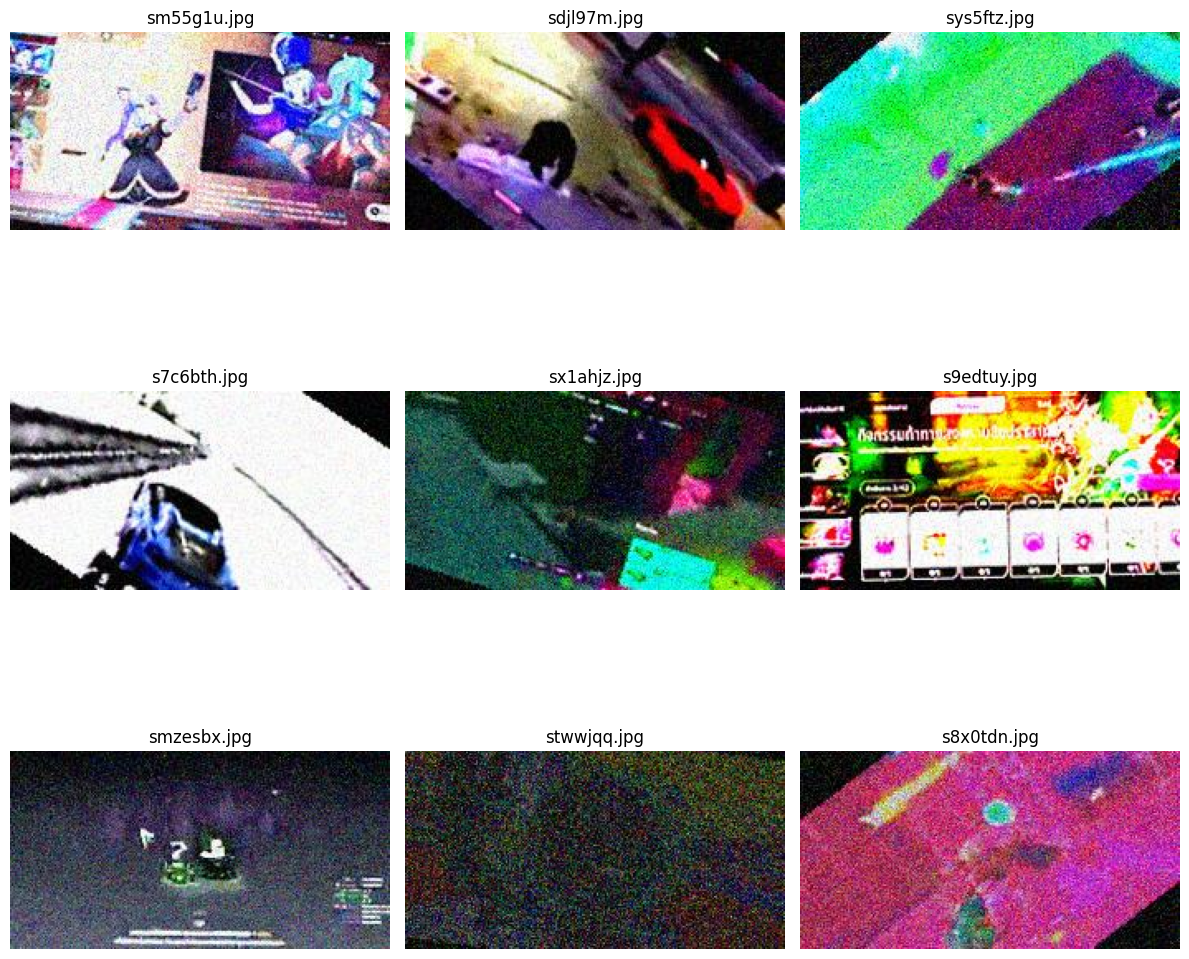

## Explore Class Distribution

Train samples: 31546
Valid samples: 24772


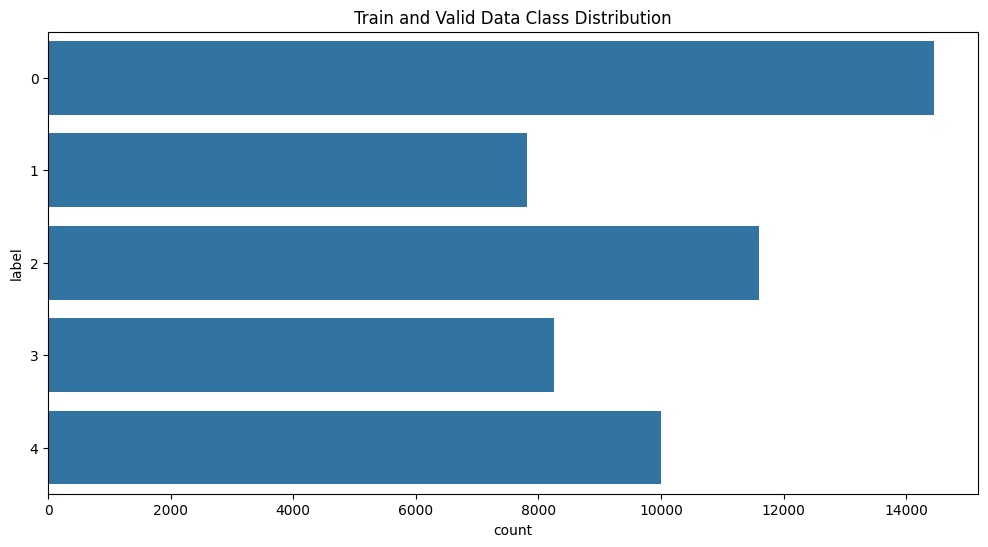

Total Classes: 5


In [ ]:
# Load CSV

# For Colab
df_train = pd.read_csv(TRAIN_CSV)
df_valid = pd.read_csv(VALID_CSV)
df_test  = pd.read_csv(TEST_CSV)
df_train_valid = pd.read_csv(TRAIN_VALID_CSV)

# For local PC
# df_train = pd.read_csv('train.csv')
# df_valid = pd.read_csv('val.csv')
# df_test  = pd.read_csv('test.csv')

print(f"Train samples: {len(df_train)}")
print(f"Valid samples: {len(df_valid)}")

# --- EDA: Class Distribution ---
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train_valid, y='label')
plt.title('Train and Valid Data Class Distribution')
plt.show()

# เก็บจำนวน Class ไว้ใช้ตอนสร้างโมเดล
NUM_CLASSES = len(df_train['label'].unique())
print(f"Total Classes: {NUM_CLASSES}")

# 3.Preporcessing

## Dealing with imbalance

In [ ]:
# จัดการกับ Imbalance โดยใช้ Class Weights
# ใช้ y_train ที่เป็นตัวเลข (label)
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(df_train_valid['label']),
    y=df_train_valid['label']
)

# Keras ต้องการ class_weight ในรูป Dictionary (map จาก ID ไปยัง weight)
class_weights_dict = dict(enumerate(class_weights_array))

print("Class Weights ที่จะใช้:")
print(class_weights_dict)

Class Weights ที่จะใช้:
{0: np.float64(0.7213257680597841), 1: np.float64(1.3334100793041699), 2: np.float64(0.8986724137931035), 3: np.float64(1.261905338336763), 4: np.float64(1.0432946357085668)}


## Clean pipeline

### Filter Too Bright and Too Dark Image

In [ ]:
BRIGHT_LOW = 40               # < 40 = มืดเกินไป
BRIGHT_HIGH = 220            # > 220 = สว่างเกินไป

# Output folders
bad_dir = "data/bad_images"
os.makedirs(bad_dir, exist_ok=True)

# detect fucntion
def detect_brightness(img_gray):
    return np.mean(img_gray)

def is_good_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    brightness = detect_brightness(gray)

    # "bad" conditions
    bad = (
        brightness < BRIGHT_LOW or
        brightness > BRIGHT_HIGH
        # border_ratio > BLACK_BORDER_THRESHOLD
        # has_color_abnormality or
        # has_color_cast
    )

    return not bad


# filter fucntion
def filter_dataset(img_dir):
    files = os.listdir(img_dir)

    for fname in tqdm(files):
        src_path = os.path.join(img_dir, fname)

        img = cv2.imread(src_path)
        if img is None:
            continue

        good = is_good_image(img)

        if not good:
            # copy ไฟล์ไป bad_images/
            shutil.copy(src_path, os.path.join(bad_dir, fname))

INPUT_PATH = 'data/train_valid'
filter_dataset(INPUT_PATH)
print("Done! Bad images copied to 'bad_images/'")

100%|██████████| 56318/56318 [00:21<00:00, 2645.87it/s]

Done! Bad images copied to 'bad_images/'


In [ ]:
# Count the number of image that were filtered to bad_images folder
folder_path = 'data/bad_images'
file_count = 0
for entry in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, entry)):
        file_count += 1

print(f"Number of files in '{folder_path}': {file_count}")

Number of files in 'data/bad_images': 4195


In [ ]:
# Visulize some image in bad_images folder
random.seed(42)
bad_images_path = 'data/bad_images'
image_files = [f for f in os.listdir(bad_images_path) if os.path.isfile(os.path.join(bad_images_path, f))]

num_images = 9
random_images = random.sample(image_files, min(num_images, len(image_files)))

plt.figure(figsize=(12, 12))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(bad_images_path, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_rgb)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

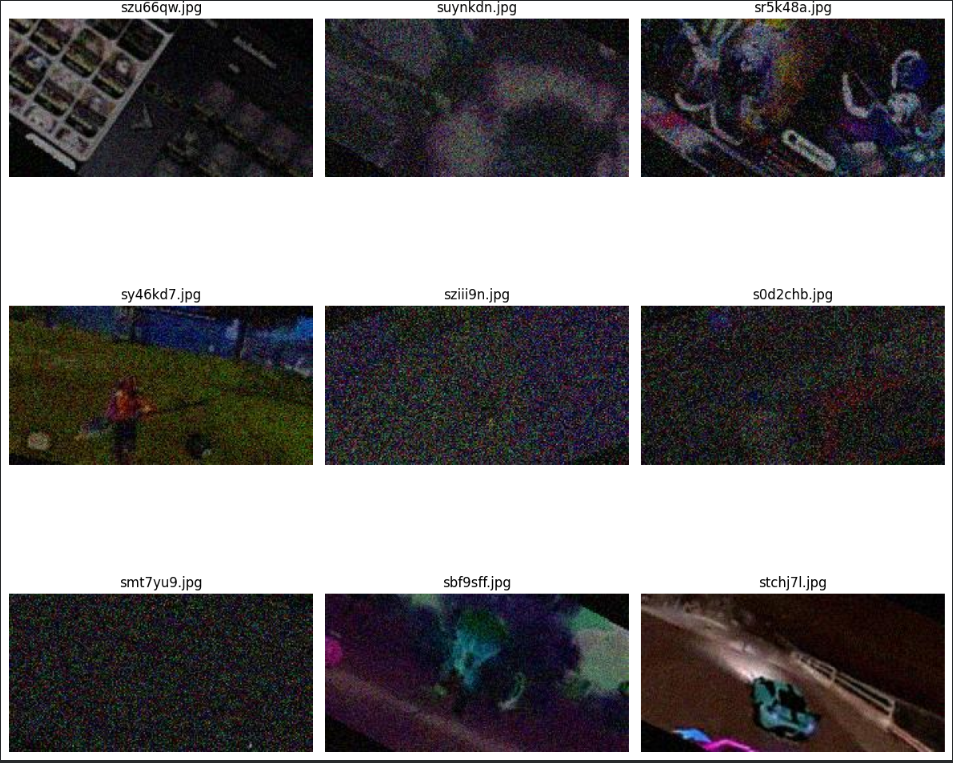

### Remove image in bad_images folder from train_valid dataset

In [ ]:
bad_images_path = 'data/bad_images'
bad_image_files = set(os.listdir(bad_images_path))

# 1. Remove bad images from train_valid folder
train_valid_path = 'data/train_valid'
removed_count = 0

for fname in bad_image_files:
    img_path = os.path.join(train_valid_path, fname)
    if os.path.exists(img_path):
        os.remove(img_path)
        removed_count += 1

print(f"Removed {removed_count} bad images from {train_valid_path}")

# 2. Remove bad images from train_valid.csv
df_train_valid = pd.read_csv('data/train_valid.csv')
print(f"Original CSV size: {len(df_train_valid)}")

df_train_valid_clean = df_train_valid[~df_train_valid['file_name'].isin(bad_image_files)]

print(f"Cleaned CSV size: {len(df_train_valid_clean)}")
print(f"Removed {len(df_train_valid) - len(df_train_valid_clean)} rows from CSV")

# Save cleaned CSV
df_train_valid_clean.to_csv('data/train_valid_clean.csv', index=False)
print("Saved cleaned CSV as 'train_valid_clean.csv'")

Removed 4195 bad images from data/train_valid
Original CSV size: 56318
Cleaned CSV size: 52123
Removed 4195 rows from CSV
Saved cleaned CSV as 'train_valid_clean.csv'


# 4.Data Pipeline

## Building Pipeline

In [ ]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

In [ ]:
def resize_image(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, label

In [ ]:
# *** This part were done locally ***
# *** This Part consume CPU so I have to make it an offline process instead ***

# Non-Local Mean denoising
def nlm_denoise(image):
    img_np = image.numpy()
    denoised = cv2.fastNlMeansDenoisingColored(
        img_np,
        None,
        h=8,
        hColor=10,
        templateWindowSize=7,
        searchWindowSize=21
    )
    return denoised

def apply_nlm(image, label):
    processed = tf.py_function(
        func=nlm_denoise,
        inp=[image],
        Tout=tf.uint8
    )
    processed.set_shape(image.shape)
    return processed, label

image.png

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(img, label):
    return preprocess_input(img), label

In [ ]:
def build_dataset(df, img_root, is_train=True):
    paths = [os.path.join(img_root, f) for f in df['file_name']]
    labels = df['label']

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if is_train:
        ds = ds.shuffle(len(df))

    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE) # uint8

    # Done on my local
    # if is_train:
    #     ds = ds.map(apply_nlm, num_parallel_calls=AUTOTUNE) # uint8

    ds = ds.map(resize_image, num_parallel_calls=AUTOTUNE) # float32


    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return ds

## Spliting and Building Tf dataset

In [ ]:
df_train_split, df_valid_split = train_test_split(
    df_train_valid,
    test_size=0.2,
    stratify=df_train_valid['label'],
    random_state=42
)

In [ ]:
train_ds = build_dataset(df_train_split, TRAIN_VALID_DIR, is_train=True)
valid_ds = build_dataset(df_valid_split, TRAIN_VALID_DIR, is_train=True)
test_ds = build_dataset(df_test, TEST_IMG_DIR, is_train=False)

## Visualize dataset build

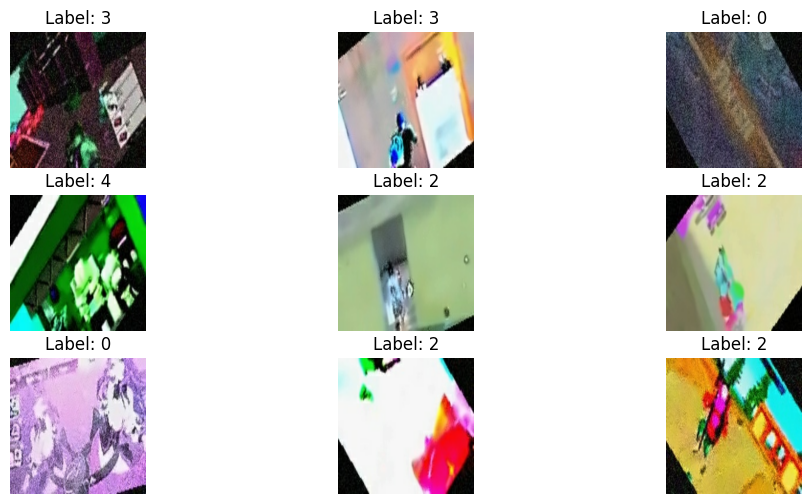

In [ ]:
# train dataset

for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

In [ ]:
# test dataset

for images, labels in test_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

# 5.Model Building

In [ ]:
# Base model
base = EfficientNetV2B0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base.trainable = False

# Build model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,925,717 (22.60 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

# 6.Model Training

## Phase 1: Head training (Backbone Freeze)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    class_weight=class_weights_dict
)

Epoch 1/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 125s 71ms/step - accuracy: 0.5974 - loss: 1.0353 - val_accuracy: 0.7563 - val_loss: 0.6673
Epoch 2/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 61s 46ms/step - accuracy: 0.7360 - loss: 0.7204 - val_accuracy: 0.7686 - val_loss: 0.6190
Epoch 3/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 62s 47ms/step - accuracy: 0.7492 - loss: 0.6809 - val_accuracy: 0.7889 - val_loss: 0.5823
Epoch 4/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 61s 46ms/step - accuracy: 0.7537 - loss: 0.6748 - val_accuracy: 0.7901 - val_loss: 0.5700
Epoch 5/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 62s 47ms/step - accuracy: 0.7550 - loss: 0.6648 - val_accuracy: 0.7941 - val_loss: 0.5614
Epoch 6/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 60s 46ms/step - accuracy: 0.7579 - loss: 0.6528 - val_accuracy: 0.7968 - val_loss: 0.5537
Epoch 7/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 62s 47ms/step - accuracy: 0.7604 - loss: 0.6499 - val_accuracy: 0.7992 - val_loss: 0.5474
Epoch 8/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 61s 46ms/step - accuracy: 0.7580 

In [ ]:
os.makedirs('saved_models', exist_ok=True)
model.save('saved_models/efficientnet_frozen_base.keras')
print('Phase 1 model saved')

Phase 1 model saved


## Phase 2: Fine-tune (Unfreeze Backbone)

In [ ]:
base_model = tf.keras.models.load_model('saved_models/efficientnet_frozen_base.keras')

base_model.layers[1].trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

base_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callback
checkpoint = ModelCheckpoint(
    'efficientnet_best_finetune.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

early = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [ ]:
history_finetune = base_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, reduce_lr, early]
)

Epoch 1/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 310s 170ms/step - accuracy: 0.5578 - loss: 1.1659 - val_accuracy: 0.7633 - val_loss: 0.6514 - learning_rate: 1.0000e-05
Epoch 2/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 182s 140ms/step - accuracy: 0.7389 - loss: 0.7103 - val_accuracy: 0.8315 - val_loss: 0.4693 - learning_rate: 1.0000e-05
Epoch 3/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 192s 132ms/step - accuracy: 0.8062 - loss: 0.5389 - val_accuracy: 0.8668 - val_loss: 0.3834 - learning_rate: 1.0000e-05
Epoch 4/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 174s 133ms/step - accuracy: 0.8440 - loss: 0.4429 - val_accuracy: 0.8803 - val_loss: 0.3409 - learning_rate: 1.0000e-05
Epoch 5/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 173s 133ms/step - accuracy: 0.8703 - loss: 0.3644 - val_accuracy: 0.9017 - val_loss: 0.2834 - learning_rate: 1.0000e-05
Epoch 6/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 174s 133ms/step - accuracy: 0.8940 - loss: 0.3072 - val_accuracy: 0.9063 - val_loss: 0.2648 - learning_rate: 1.0000e-05
Epoch 7/20
1304/1304 ━━━━━━━

In [ ]:
base_model.save('saved_models/efficientnet_finetuned.keras')
print('Fine-tuned model saved')

Fine-tuned model saved


In [ ]:
# save history

import pickle
with open('saved_models/training_history.pkl', 'wb') as f:
    pickle.dump({
        'phase1': history.history,
        'phase2': history_finetune.history
    }, f)

# 7.Evaluate

### Classification Report

In [ ]:
finetune_model = tf.keras.models.load_model('saved_models/efficientnet_finetuned.keras')

In [ ]:
# Classification Report

y_true = []
y_pred = []
for images, labels in valid_ds:
    preds = finetune_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred))
# cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━

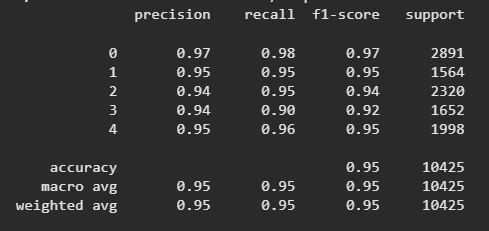

### Accuracy Vs. Loss

In [ ]:
# Accuracy Vs. Loss Plotting

def plot_history(history, title="Training History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # ---- Accuracy ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, val_acc, label='val_acc')
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # ---- Loss ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


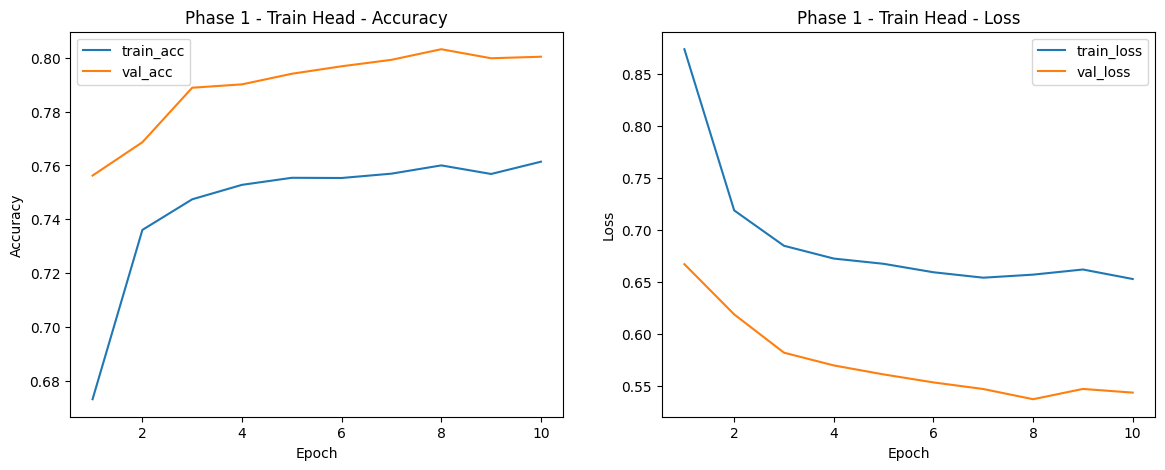

In [ ]:
plot_history(history, title="Phase 1 - Train Head")

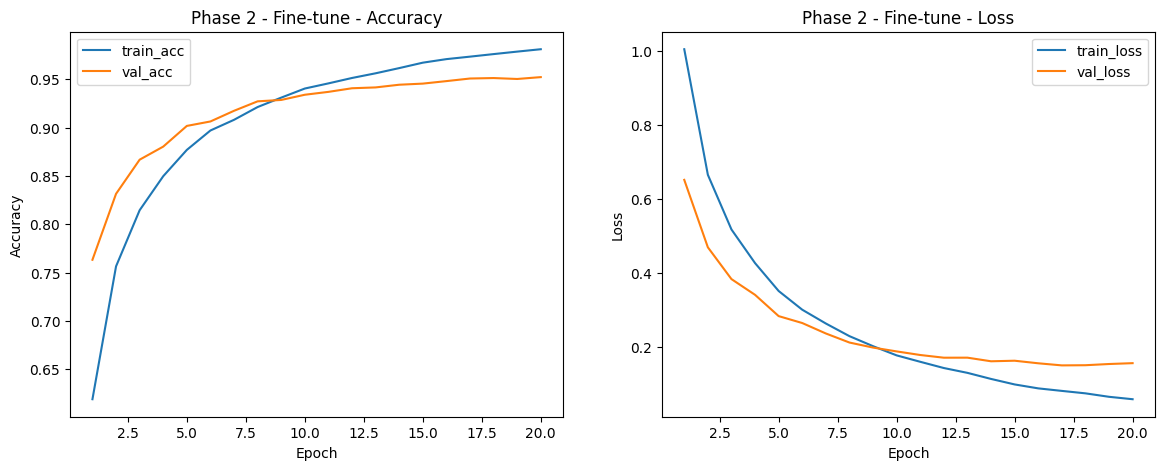

In [ ]:
plot_history(history_finetune, title="Phase 2 - Fine-tune")

# 8.Create Submission
* This part were done locally

## Generate Submission CSV

In [ ]:
# Get predictions from test dataset
print("Generating predictions...")
finetune_model = tf.keras.models.load_model('efficientnet_finetuned.keras')

predictions = finetune_model.predict(test_ds)

# Get predicted class
predicted_labels = np.argmax(predictions, axis=1)

df_test_submission = df_test.copy()

# Add predictions to dataframe
df_test_submission['label'] = predicted_labels

## Visualize some prediction

In [ ]:
# Visualize predictions
random.seed(42)
sample_indices = random.sample(range(len(df_test_submission)), 9)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(sample_indices):
    img_name = df_test_submission.iloc[idx]['file_name']
    pred_label = df_test_submission.iloc[idx]['label']

    # Load image
    img_path = os.path.join('test', img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"{data_class[pred_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

image.png

## Generate Submission CSV (Continue)

In [ ]:
df_submission = df_test_submission.drop('file_name', axis=1)

# Save submission file
df_submission.to_csv('submission_task4.csv', index=False)

print("Submission file created!")
print(df_submission.head())